### Figure 1
- schematic
- spectrogram for NSD and SD
- percentage sleep fraction during first 5h of POST for both SD and NSD sessions


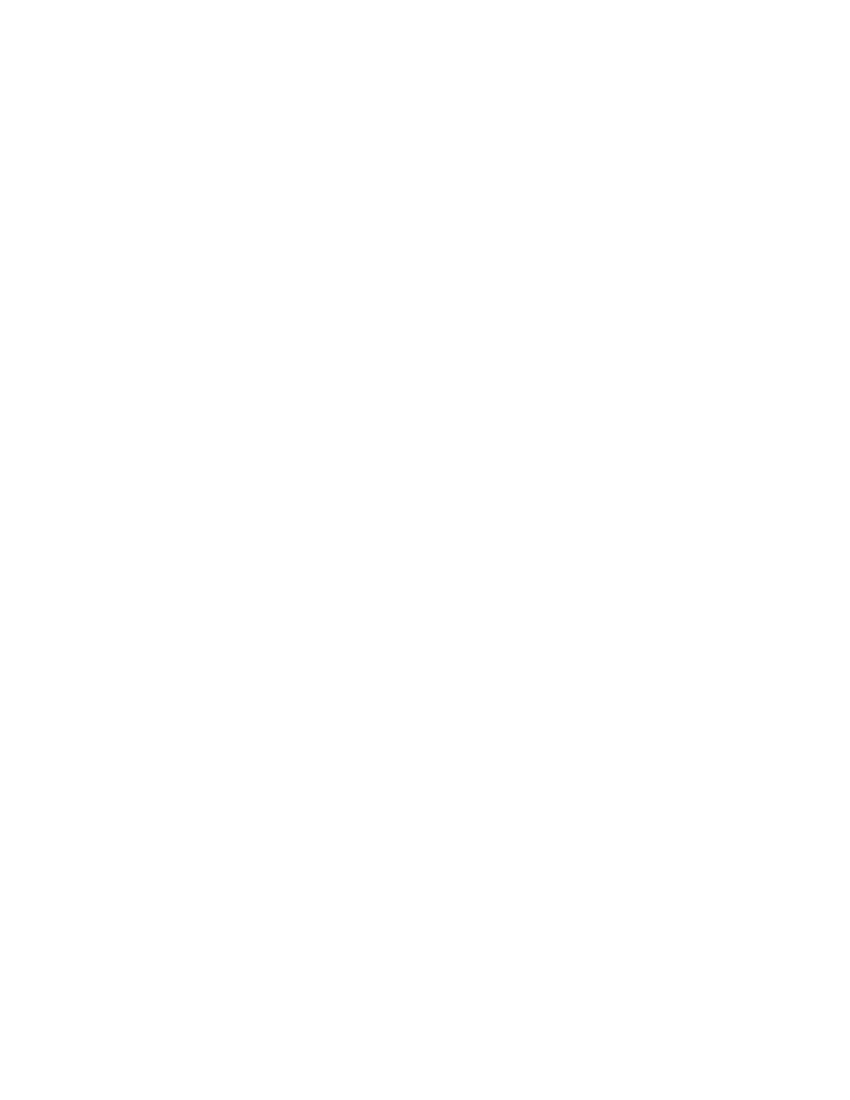

In [29]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from subjects import sd_span,nsd_span,grp_span,light_cycle_span,epoch_span



grpdata = subjects.GroupData()
group = ["nsd", "sd"]

# brainstates 
states = grpdata.brainstates_proportion

#frate
frate = grpdata.frate_zscore
frate_change = grpdata.frate_change_1vs5
colors_frate_change = subjects.colors_sd(1.2)

frate_quantiles = grpdata.frate_pre_to_maze_quantiles_in_POST
frate_quantiles_shuffled= grpdata.frate_pre_to_maze_quantiles_in_POST_shuffled

fig = Fig(grid=(4,3), hspace=0.45, wspace=0.4)
filename = subjects.figpath_sd / "figure1"

caption = "Figure 1: Changes to firing rate across SD and NSD sessions. \n(A) Slow wave amplitude during POST of example SD and NSD sessions from one animal.\n(B) Porportion time spent in each vigilance state in first 5 h of POST pooled across SD (left) and NSD (right).\n(C) Mean firing rates across across session pooled across animals. Light/dark cycles and sessions epochs are indicated above x-axis.\n(D) Percentage change in firing rate from 1st to 5th hour POST.\n(E) Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Error bars indicate SEM." 


### sleep fraction

In [30]:
ax = fig.subplot(fig.gs[0, 2])
hue = ["active", "quiet", "rem", "nrem"]
color = list(subjects.sleep_colors.values())
ax = sns.boxplot(
    data=states,
    x="grp",
    y="prop",
    hue="state",
    ax=ax,
    hue_order=hue,
    palette=subjects.sleep_colors,
    showfliers=False,
    linewidth=1,
    boxprops=dict(edgecolor='none'),
    showcaps=False,
    medianprops=dict(color='w',lw=2),
    # capsize=0.05,
    # legend= None,
)
# for i,artist in enumerate(ax.artists):
#     # Set the linecolor on the artist to the facecolor, and set the facecolor to None
#     col = artist.get_facecolor()
#     artist.set_edgecolor(col)
#     artist.set_facecolor('None')

#     # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
#     # Loop over them here, and use the same colour as above
#     for j in range(i*6,i*6+6):
#         line = ax2.lines[j]
#         line.set_color(col)
#         line.set_mfc(col)
#         line.set_mec(col)
ax.legend([],frameon=False)
fig.legend(ax,subjects.sleep_colors.keys(),subjects.sleep_colors.values(),x=0.5)
ax.set_ylabel("State proportion")

ax.set_title("First 5 h of POST ")
fig.panel_label(ax=ax, label="B")

### zscored firing rate

In [31]:
# neuron_colors = ["#f52e14", "#0a8a46"]
neuron_colors = [subjects.colors_sd(1),subjects.colors_sd(1.5)]
gs_frate = fig.subplot2grid(fig.gs[1, :], grid=(1, 2), wspace=0.15)
for i, neuron_type in enumerate(["pyr", "inter"]):

    neur_color = neuron_colors[i]

    for i1, (grp, grp_color) in enumerate(
        zip(
            group,
            neur_color
        )
    ):
        ax_frate = fig.subplot(gs_frate[i1])
        df = frate[(frate["grp"] == grp) & (frate["neuron_type"] == neuron_type)]

        mean_frate = df.groupby("bins").mean()
        x = mean_frate.index
        y = mean_frate.frate.values
        err = df.groupby("bins").sem(ddof=0).frate.values
        ax_frate.fill_between(
            x, y - err, y + err, color=grp_color, alpha=0.3, ec=None, zorder=1
        )
        ax_frate.plot(x, y, grp_color, lw=1, zorder=2)

        ax_frate.set_title(f"{grp.upper()} sessions", loc="left")
        # baseline=====
        df_pre = frate[frate["bins"] < -1]
        df_pre_mean = df_pre.groupby("bins").mean().mean().frate
        ax_frate.axhline(df_pre_mean, ls="--", color="gray")


        light_cycle_span(ax_frate,-4.2,9)
        epoch_span(ax_frate)

        ax_frate.set_xlabel("ZT time (h)")
        ax_frate.set_xlim([-4, 9])

        # ax_frate.axvline(0,ls='--',color='gray')
        # ax_frate.axvline(5,ls='--',color='gray')

        if i1 == 1:
            ax_frate.text(2, 0.5, "SD", fontsize=8)
            ax_frate.text(7, 0.5, "RS", fontsize=8)
            ax_frate.axvspan(
                0, 5, 0.8, 0.85, color="#f9951a", alpha=0.5, zorder=0, ec=None
            )
            ax_frate.axvspan(
                5, 9, 0.8, 0.85, color="#f19de9", alpha=0.5, zorder=0, ec=None
            )
            ax_frate.set_ylabel("Normalized firing rate")
        if i1==0:
            fig.panel_label(ax_frate, "C")

        ax_frate.set_ylim([-1.2, 1.85])


### frate change from Zt1 to Zt5

In [32]:
df

,bins,frate,neuron_type,sub,grp
337539,-4.200000,2.845876,inter,0,sd
337540,-4.183333,2.830469,inter,0,sd
337541,-4.166667,2.784248,inter,0,sd
337542,-4.150000,2.707212,inter,0,sd
337543,-4.133333,2.614768,inter,0,sd
...,...,...,...,...,...
358956,8.916667,-0.410935,inter,4,sd
358957,8.933333,-0.405058,inter,4,sd
358958,8.950000,-0.393304,inter,4,sd
358959,8.966667,-0.393304,inter,4,sd


In [33]:
from statannotations.Annotator import Annotator

ax_1v5 = fig.subplot(fig.gs[2, 0])
# sns.violinplot(
#         data=frate_1v5_df, x="neuron_type", y="frate",hue='grp', palette=colors, ax=ax_1v5, size=2.7, saturation=1,split=True,inner=None
#     )
df = frate_change.replace([np.inf, -np.inf], np.nan)
df.dropna(how="all", inplace=True)
sns.boxplot(
    data=df,
    x="neuron_type",
    y="frate",
    hue="grp",
    palette=colors_frate_change,
    ax=ax_1v5,
    hue_order=group,
    width=0.5,
    # alpha=0.5,
    showfliers=False,
    # split=True,
    boxprops=dict(edgecolor="none"),
    showcaps=False,
    medianprops=dict(color="w", lw=2),
)

ax_1v5.legend("", frameon=False)

# df = frate_1v5_df[frate_1v5_df['neuron_type']=='pyr']
# sns.histplot(
#         data=df, x="frate",hue='grp', palette=colors, ax=ax_1v5,stat='probability',fill=False,common_bins=True,element='step',
#     )

# ax_1v5.set_yscale('log')
ax_1v5.set_ylabel("%change from 1st to 5th hour ")

pairs = [(("pyr", "nsd"), ("pyr", "sd")),(("inter", "nsd"), ("inter", "sd"))]

annotator = Annotator(
    ax_1v5, pairs, data=df, x="neuron_type", y="frate", order=["pyr", "inter"],hue='grp',hue_order=group
)
annotator.configure(test="t-test_ind", text_format="star", loc="inside")
annotator.apply_and_annotate()


fig.panel_label(ax_1v5, "D")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

inter_nsd vs. inter_sd: t-test independent samples, P_val:4.811e-01 t=7.074e-01
pyr_nsd vs. pyr_sd: t-test independent samples, P_val:2.707e-02 t=-2.215e+00


### pre-to-maze quantiles firing rate

In [34]:
from palettable.colorbrewer.sequential import Oranges_6, Purples_6,Reds_6,Greys_6

colors = subjects.colors_sd(1)
palette = [Greys_6,Reds_6]
for i, grp in enumerate(["nsd", "sd"]):
    ax_1v5 = fig.subplot(fig.gs[2,i+1])
    df = frate_quantiles[(frate_quantiles["grp"] == grp)]
    df_shuffled = frate_quantiles_shuffled[(frate_quantiles_shuffled["grp"] == grp)]
    sns.lineplot(
        data=df_shuffled,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=['#ababab']*5,
        legend=None,
        ax=ax_1v5,
        alpha = 0.5,
        # estimator = np.nanmean,
    )
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
        ax=ax_1v5
    )   
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.4,top=1.9)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    if i==0:
        fig.panel_label(ax_1v5,'E')

### saving

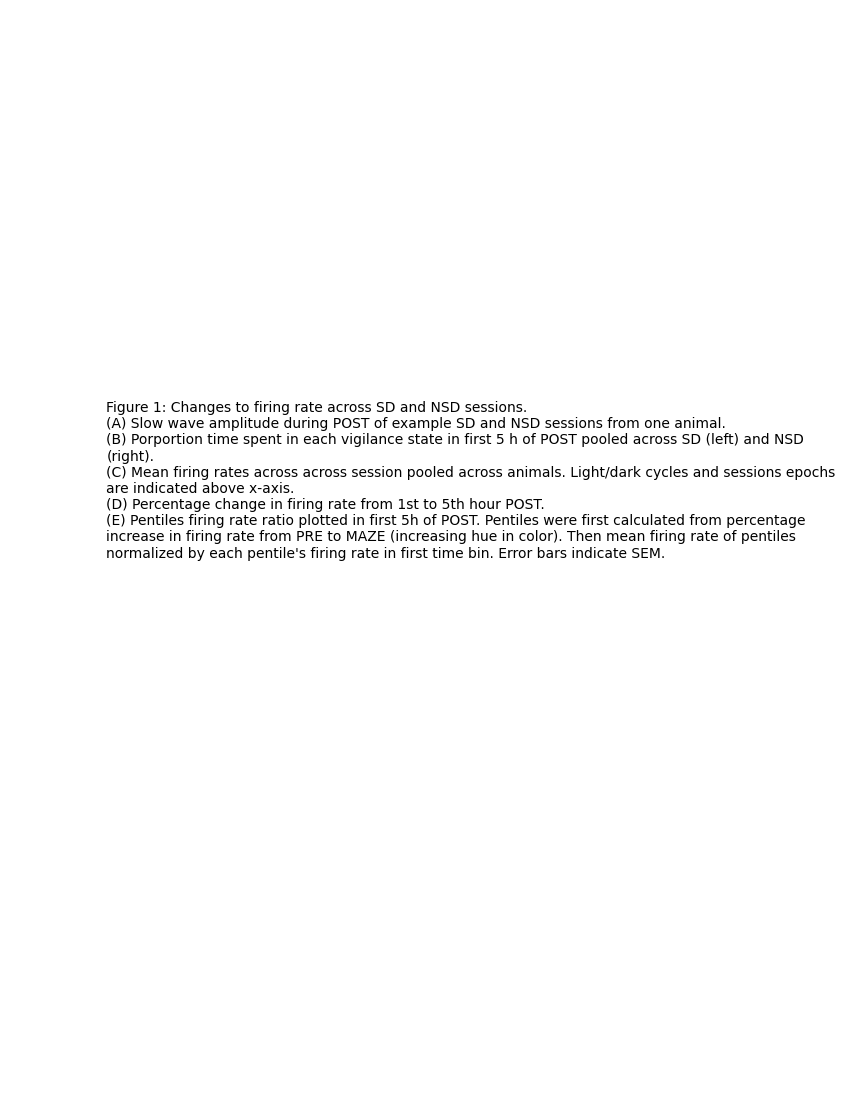

In [35]:
fig.savefig(subjects.figpath_sd/'figure1',caption=caption)